Benchmarks for model order reduction in finance
============

### Benchmark Case 1: Yield Curve Simulation

The first proposed benchmark case is to validate the numerical methods implemented for the simulation of yield curves and parameter calibration.

We perform a principal component analysis on the collected historical 
data to ensure that the simulation results in a consistent curve. 
Further, using the principal components corresponding to their maximum energies, 
we calculate the consistent interest rates and composed them into 
a matrix called as the matrix of returns. 
Finally, we obtain the simulated yield curve by applying the bootstrapping 
procedure on the matrix of returns. To fulfill the regulations demand,
we perform the bootstrapping process for at least 10,000 times. 
The detailed procedure can be found in the PRIIPs regulations.

Run file named 'YieldCurveSimulation.m' for the first Benchmark

Inputs:
- Historical Interest rate data : A

Outputs:
- Simulated yield curves : Sim_return
- Simulated yield curves in Percentage: Sim_returnPerc
- Simulated yield curve plot


### Installation

Install the input/output and statistics Ocatave package for reading/writting .xlsx files and manage random samples

In [1]:
pkg install -forge io statistics
pkg load io statistics


The gnuplot graphics toolkit is not actively maintained and has a number
of limitations that are ulikely to be fixed.  Communication with gnuplot
uses a one-directional pipe and limited information is passed back to the
Octave interpreter so most changes made interactively in the plot window
will not be reflected in the graphics properties managed by Octave.  For
example, if the plot window is closed with a mouse click, Octave will not
be notified and will not update it's internal list of open figure windows.
We recommend using the qt toolkit instead.

For information about changes from previous versions of the statistics package, run 'news statistics'.
error: source: No such file or directory


### Computations

Read the interest rate matrix (historical data)

In [12]:
A = xlsread('../benchmarks/HistoricalData.xlsx');
%% Correct the interest rates making sure all elements are positive

a = 0.1; % correction factor
corr_A1 = A+a;
% corr_A = corr_A1(:,[5 8:end]);
corr_A = corr_A1;
%all(corr_A,1); %check whether all elements are positive
B = zeros(1306,20);

for i=2:1306
    for j=1:20
        B(i,j) = log(corr_A(i,j)/corr_A(i-1,j)); % 23(iii) PRIIPS
    end
end

B1 = B(2:end,:);


Correct the returns for zero mean

In [13]:
mean_B = mean(B1,1);
mean_mat = zeros(1305,20);
for i=1:20
    mean_mat(:,i) = mean_B(:,i);
end

BarBarA= B1 - mean_mat;

Convariance Matrix

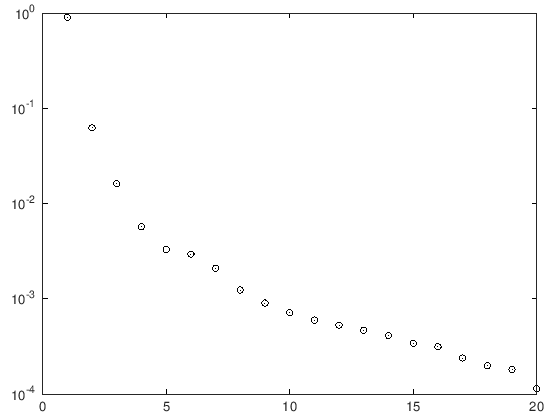

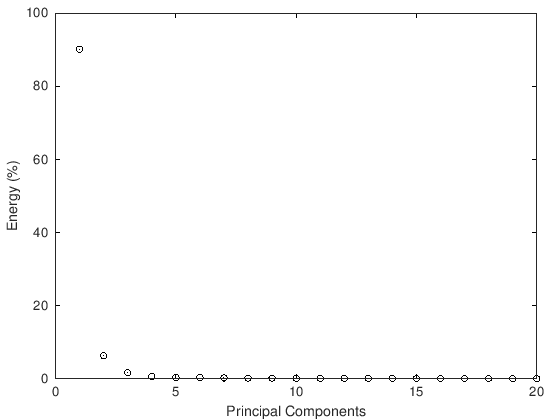

In [14]:
B1T = transpose(BarBarA);
%
covarianceMat = B1T*BarBarA;
%
p =10;
[Vr, Fig1, Fig2] = PCA_YC(BarBarA, p);

BVr = BarBarA*Vr; % 23 (a)(ix)

Matrix of Returns

In [15]:
VrT = transpose(Vr);
Matreturns = BVr * VrT; %23 (a)(x)
Matreturns_1 = [Matreturns;Matreturns;Matreturns];

Forward Rates

In [16]:
rc = corr_A(1306,:); %Current Value at tenor
r = zeros (1,20); 

Query points for interpolation. These are the points where we dont have historical data, thus interpolation. See Binder017 for more details. See also PRIIPs regulations for more details

In [17]:
% Query points 10 years
xq = [(10+(92/260)) (10+(183/260)) (10+(275/260)) 11 13 14 16 17 18 19 22 35 60];

% Query points 5 years
% xq = [(65/260)+5 (130/260)+5 (195/260)+5 11 13 14 17 35 45 55];
% % FR=xlsread('FR.xlsx');

HP = 'ten'; % ten or five

[Interp_Rates] = Interpolate(A, xq, HP);

A_temp = A;

rc1 = A_temp(1306,:);

%% 10 yr
TX = [(65/260)+10 (130/260)+10 (195/260)+10 11 12 13 14 15 16 17 18 19 20 22 25 30 35 40 50 60];
TY = [(65/260) (130/260) (195/260) 1 2 3 4 5 6 7 8 9 10 12 15 20 25 30 40 50];

%% 5 yr
% TX = [(65/260)+5 (130/260)+5 (195/260)+5 6 7 8 9 10 11 12 13 14 15 17 20 25 30 35 45 55];
% TY = [(65/260) (130/260) (195/260) 1 2 3 4 5 6 7 8 9 10 12 15 20 25 30 40 50];

for j = 1:20
    r(:,j) = (Interp_Rates(:,j)*TX(:,j) - rc1(:,j)*TY(:,j))/(TX(:,j) - TY(:,j)); %Compounded FR
end

Simulations: Simulated yield curves ans its mean

In [18]:
adjust_Mat1 = zeros(10000,20);
Second_shiftMat = zeros(10000,20);
for i = 1:10000
    a = randsample(length(Matreturns_1),2600);
    Sel = Matreturns_1(a,:); %Randomly selected rows (23(b) (i))
    rs = sum(Sel,1);
    ers = exp(rs);
    ers11 = rc.*ers; %corrected interest rates adjustment 23(b) (ii)
    adj1 = ers11 - 0.1;
    adjust_Mat1(i,:) = adj1;
end
mean_adj1 = mean(adjust_Mat1,1);
Second_shift = r - mean_adj1;
for i = 1:20
    Second_shiftMat(:,i) = Second_shift(:,i);
end

%% Simulated yield curves
Sim_return = adjust_Mat1+Second_shiftMat; %Second Adjustment 23(b) (ii)

%% Mean of simulated yield curves
mean_sim = mean(Sim_return);
    %Sim_return(i,:) = Return;
%% Final simulated yield curves in %
Sim_returnPerc = Sim_return.*100; %Percentage Simulated Returns
% xlswrite('Sim_returns_Perct_10_c10_5yr.xlsx',Sim_return);
TenorPoints = [(65/260) (130/260) (195/260) 1 2 3 4 5 6 7 8 9 10 12 15 20 25 30 40 50];

Plot and write (only the first 100 curves)

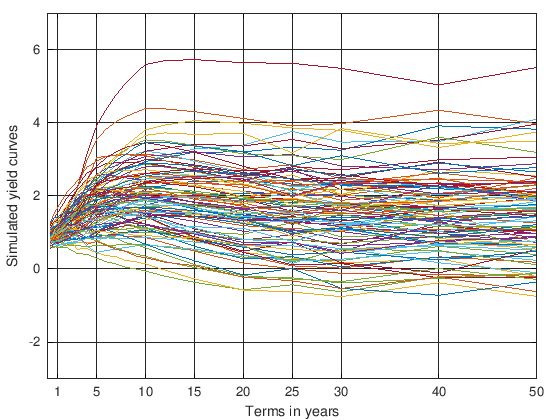

In [23]:
X = [1 5 10 15 20 25 30 40 50];
T1 = [(65/260) (130/260) (195/260) 1 2 3 4 5 6 7 8 9 10 12 15 20 25 30 40 50];
plot(T1,Sim_returnPerc(1:100,:)')
%set(gca,'FontSize',14)
%set(gcf, 'Position',  [100, 100, 800, 500])
%ax.FontSize = 14;
xticks(X);
ylim([-3 7]);
xlabel('Terms in years','fontsize',18,'interpreter','latex');
ylabel('Simulated yield curves','fontsize',18,'interpreter','latex');
grid on
%xlswrite('../Benchmarks/SimulatedYieldCurves.xlsx', Sim_return(:,[1 4:13]));